# Final Project 

**Title**: Deep Fake Detection

**Contributors**: Adam Haile, Alhagie Boye, Rudolph Evonich

**Onjective**: To develop a robust CNN model capable of accurately classifying video frames as real or fake.


This is a demo of our CNN model that will be use to classify videos as real or fake.


In [1]:
import os
import cv2
import json
import glob
import time
import random
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from sklearn.utils import shuffle
from video_utils import load_data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

2023-12-06 11:14:16.354690: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-06 11:14:16.392902: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-06 11:14:16.392932: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-06 11:14:16.394007: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-06 11:14:16.400148: I tensorflow/core/platform/cpu_feature_guar

In [2]:
K.clear_session()

# Data Loading & Data Preprocessing
The following cells handles the loading of video data and associated metadata and data preprocessing. The dataset is the [Deepfake Challenge Dataset](https://www.kaggle.com/c/deepfake-detection-challenge) from META

Video files and their corresponding metadata are retrieved from a designated directory (train_sample_videos/) and a JSON file (metadata.json).

A custom video utilities module is utilized to extract frame from each video for further processing.

The orientation of the frames is checked, and those with vertical orientation are rotated to ensure consistency. Frames are also scaled from 1920x1080 to 640x360.

Based on the metadata information, binary labels are assigned to each frame: 1 for "FAKE" videos and 0 for "REAL" videos.

In [3]:
parent = os.path.dirname(os.getcwd())
videos = glob.glob(parent + "/train_sample_videos/*.mp4")
f = open(parent + "/train_sample_videos/metadata.json")
valid = json.load(f)

In [4]:
train_X, test_X, val_X, train_y, test_y, val_y = load_data(videos, valid, verbose=True)
train_X, train_y = shuffle(train_X, train_y, random_state=2)

Processing train videos...
Oversampled training videos. Original size: 280, New size: 439


100%|██████████| 439/439 [03:55<00:00,  1.86it/s]


Processing test videos...
Oversampled testing videos. Original size: 80, New size: 128


100%|██████████| 128/128 [01:07<00:00,  1.88it/s]


Processing validation videos...
Oversampled testing videos. Original size: 40, New size: 52


100%|██████████| 52/52 [00:28<00:00,  1.80it/s]


In [5]:
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)
print(val_X.shape)
print(val_y.shape)

(13170, 360, 640, 3)
(13170, 2)
(3840, 360, 640, 3)
(3840, 2)
(1560, 360, 640, 3)
(1560, 2)


# Model Creation and Training
This cell creates the CNN model to be trained.

The model consists of the following architecture:
- Conv2D – 32 filters, (3x3) kernel, ReLU activation, input shape of (640, 360, 3)
- MaxPool2D – (2x2) Pool size
- Dropout – 20% dropout
- Conv2D – 64 filters, (3x3) kernel, ReLU activation
- MaxPool2D – (2x2) Pool size
- Dropout – 20% dropout
- Flatten – Convert 3D matrix to 1D vector
- Dense – 16 neurons, ReLU activation
- Output Dense – 2 neurons, Softmax activation


The dataset is split into training, testing, and validation sets to assess the model's performance during training.

The model is trained on the training set for a specified number of epochs 10 epochs at a batch size of 16.

The training and validation accuracy are visualized over epochs using matplotlib to track the model's learning progress.


In [7]:
def create_model():
    model = tf.keras.models.Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [8]:
batch_size = 16
epochs = 10
input_shape = (640, 360, 3)

In [9]:
model = create_model()
model.summary()

2023-12-06 11:20:16.230137: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13811 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:61:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 638, 358, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 319, 179, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 319, 179, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 317, 177, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 158, 88, 64)       0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 158, 88, 64)       0

In [10]:
datagen = ImageDataGenerator(
            samplewise_center=True, 
            rotation_range=20, 
            zoom_range = 0.01,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            vertical_flip=False)

train_it = datagen.flow(train_X, train_y, batch_size=batch_size)
    
valid_it = datagen.flow(test_X, test_y, batch_size=batch_size)

In [11]:
history = model.fit(train_it, steps_per_epoch=len(train_X)//batch_size, epochs=epochs, validation_data=valid_it)

Epoch 1/10


2023-12-06 11:20:56.463817: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-12-06 11:20:57.326972: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8901
2023-12-06 11:20:59.377509: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f539cfd6310 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-06 11:20:59.377545: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-12-06 11:20:59.382373: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1701879659.486260 2286884 device_compiler.h:186] Compiled cluster using XLA!  This line i

823/823 [==============================] - 651s 785ms/step - loss: 0.6963 - accuracy: 0.6542 - val_loss: 0.8052 - val_accuracy: 0.4568
Epoch 2/10
823/823 [==============================] - 647s 786ms/step - loss: 0.5628 - accuracy: 0.7118 - val_loss: 0.9499 - val_accuracy: 0.4534
Epoch 3/10
823/823 [==============================] - 642s 779ms/step - loss: 0.5300 - accuracy: 0.7333 - val_loss: 0.9550 - val_accuracy: 0.4677
Epoch 5/10
823/823 [==============================] - 643s 781ms/step - loss: 0.5082 - accuracy: 0.7456 - val_loss: 0.9465 - val_accuracy: 0.5023
Epoch 6/10
823/823 [==============================] - 644s 783ms/step - loss: 0.4987 - accuracy: 0.7501 - val_loss: 0.9560 - val_accuracy: 0.4987
Epoch 7/10
823/823 [==============================] - 643s 781ms/step - loss: 0.4863 - accuracy: 0.7560 - val_loss: 0.9519 - val_accuracy: 0.5164
Epoch 8/10
823/823 [==============================] - 648s 788ms/step - loss: 0.4822 - accuracy: 0.7587 - val_loss: 1.0307 - val_accura

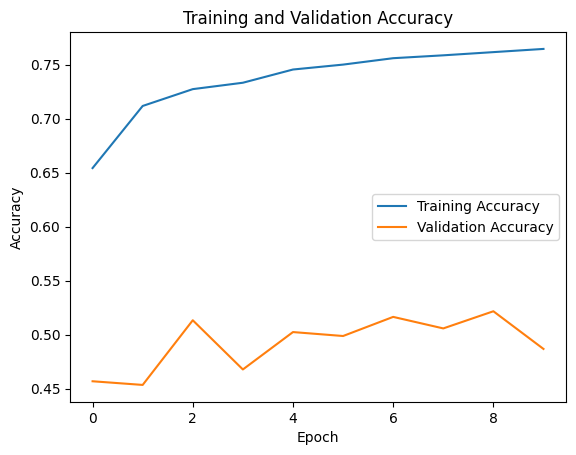

<Figure size 640x480 with 0 Axes>

In [12]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.savefig('./model_b' + str(batch_size) + '_e' + str(epochs) + '.png')

In [ ]:
evaluation = model.evaluate(val_X, val_y)
print(f"Validation Accuracy: {evaluation[1] * 100:.2f}%")

In [ ]:
model.save('model.h5')